In [6]:
import pandas as pd

# Считывание данных из Excel файла
# Предполагается, что все данные находятся в первом столбце первого листа
data = pd.read_excel('tobit.xlsx', header=None, usecols=[0])

# Разделение строк на столбцы по запятой
# Результатом будет DataFrame с несколькими столбцами
data_split = data[0].str.split(',', expand=True)

# Предполагается, что первая строка содержит заголовки столбцов
# Установим заголовки столбцов
data_split.columns = data_split.iloc[0]

# Удалим теперь первую строку, так как она содержит заголовки
data_split = data_split.drop(data_split.index[0])

# Сбросим индекс DataFrame
data_split.reset_index(drop=True, inplace=True)

# Преобразование типов данных, если необходимо
data_split['read'] = pd.to_numeric(data_split['read'])
data_split['math'] = pd.to_numeric(data_split['math'])
data_split['apt'] = pd.to_numeric(data_split['apt'])

# Конвертация категориальной переменной 'prog' в dummy переменные, если это необходимо
data_split = pd.get_dummies(data_split, columns=['prog'])

# Теперь у вас есть DataFrame, готовый для дальнейшего анализа
print(data_split.head())


  id  read  math  apt  prog_"academic"  prog_"general"  prog_"vocational"
0  1    34    40  352            False           False               True
1  2    39    33  449            False           False               True
2  3    63    48  648            False            True              False
3  4    44    41  501            False            True              False
4  5    47    43  762            False            True              False


In [7]:
# Продолжение из предыдущего кода...
# Уже имеем data_split как подготовленный DataFrame

# Преобразуем 'id' в числовой формат, если это необходимо
data_split['id'] = pd.to_numeric(data_split['id'], errors='coerce')

# Убедимся, что все нужные столбцы в правильном формате
data_split['read'] = pd.to_numeric(data_split['read'], errors='coerce')
data_split['math'] = pd.to_numeric(data_split['math'], errors='coerce')
data_split['apt'] = pd.to_numeric(data_split['apt'], errors='coerce')

# Обработаем пропущенные значения, если они есть
data_split.dropna(inplace=True)


In [8]:
import statsmodels.api as sm

# Выберем переменную для прогноза и независимые переменные
# Например, мы хотим предсказать 'apt' используя 'read' и 'math'
y = data_split['apt']
X = data_split[['read', 'math']]
X = sm.add_constant(X)  # Добавляем константу для оценки перехвата

# Оцениваем модель
model = sm.OLS(y, X).fit()

# Выводим результаты
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    apt   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     137.7
Date:                Sat, 24 Feb 2024   Prob (F-statistic):           3.83e-38
Time:                        09:50:14   Log-Likelihood:                -1115.3
No. Observations:                 200   AIC:                             2237.
Df Residuals:                     197   BIC:                             2246.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        192.5099     27.362      7.036      0.0

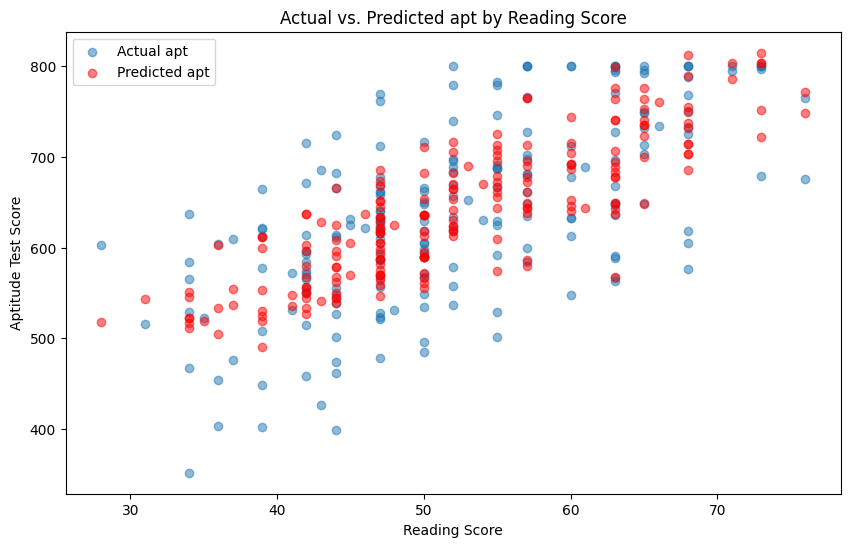

In [9]:
import matplotlib.pyplot as plt

# Предсказываем значения 'apt' с помощью модели
data_split['predicted_apt'] = model.predict(X)

# График рассеяния для 'read' и 'apt'
plt.figure(figsize=(10, 6))
plt.scatter(data_split['read'], data_split['apt'], alpha=0.5, label='Actual apt')
plt.scatter(data_split['read'], data_split['predicted_apt'], color='red', alpha=0.5, label='Predicted apt')

# Название графика и осей
plt.title('Actual vs. Predicted apt by Reading Score')
plt.xlabel('Reading Score')
plt.ylabel('Aptitude Test Score')
plt.legend()

# Показать график
plt.show()


In [10]:
from statsmodels.discrete.discrete_model import Probit
from statsmodels.iolib.summary2 import summary_col

# Определим переменную участия на основе 'apt' (например, участие, если apt > 400)
data_split['participation'] = (data_split['apt'] > 400).astype(int)

# Уравнение выбора
X_selection = sm.add_constant(data_split[['read', 'math']])
y_selection = data_split['participation']

probit_model = Probit(y_selection, X_selection).fit()
print(probit_model.summary())


Optimization terminated successfully.
         Current function value: 0.039203
         Iterations 11
                          Probit Regression Results                           
Dep. Variable:          participation   No. Observations:                  200
Model:                         Probit   Df Residuals:                      197
Method:                           MLE   Df Model:                            2
Date:                Sat, 24 Feb 2024   Pseudo R-squ.:                  0.3000
Time:                        09:55:16   Log-Likelihood:                -7.8406
converged:                       True   LL-Null:                       -11.200
Covariance Type:            nonrobust   LLR p-value:                   0.03475
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6294      4.886     -1.152      0.249     -15.206       3.947
read           0.0535      0

In [11]:
# Расчет обратной Миллса рацио
data_split['mills_ratio'] = probit_model.predict(X_selection) * (1 - probit_model.predict(X_selection))


In [12]:
# Уравнение исхода с коррекцией на обратную Миллса рацио
X_outcome = sm.add_constant(data_split[['read', 'math', 'mills_ratio']])
y_outcome = data_split['apt']

ols_model = sm.OLS(y_outcome, X_outcome).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                    apt   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     92.76
Date:                Sat, 24 Feb 2024   Prob (F-statistic):           2.11e-37
Time:                        09:55:24   Log-Likelihood:                -1114.4
No. Observations:                 200   AIC:                             2237.
Df Residuals:                     196   BIC:                             2250.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         221.0702     34.702      6.371      